In [58]:
import pandas
import konlpy
import gensim
import tensorflow as tf

## 1) 데이터 준비와 확인

In [33]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print(train_data.shape, test_data.shape)

(150000, 3) (50000, 3)


* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

## 2) 데이터 로더

In [35]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']


def preprocess(texts):
    # 토큰화 및 불용어 제거
    tokens = [token for text in texts for token in tokenizer.morphs(text) if token not in stopwords]
    return tokens

def build_vocab(tokens, num_words=None):
    # 사전 구성
    counter = Counter(tokens)
    vocab = {
        '<PAD>': 0,  # 패딩용 단어
        '<BOS>': 1,  # 문장의 시작지점
        '<UNK>': 2   # 사전에 없는(Unknown) 단어
    }
    if num_words:
        most_common = counter.most_common(num_words - len(vocab))
    else:
        most_common = counter.most_common()
    
    for i, (word, _) in enumerate(most_common, start=len(vocab)):
        vocab[word] = i

    return vocab

def texts_to_sequences(texts, word_to_index):
    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    sequences = [[word_to_index.get(token, 0) for token in tokenizer.morphs(text)] for text in texts]
    return sequences

def load_data(train_data, test_data, num_words=None):
    # 1. 중복 제거 및 NaN 결측치 제거
    train_data = train_data.drop_duplicates().dropna().reset_index(drop=True)
    test_data = test_data.drop_duplicates().dropna().reset_index(drop=True)
    
    # 2. 데이터 분리
    X_train = train_data['document'].tolist()
    y_train = train_data['label'].tolist()
    X_test = test_data['document'].tolist()
    y_test = test_data['label'].tolist()

    # 3. 텍스트 전처리 (토큰화 및 불용어 제거)
    train_tokens = preprocess(X_train)
    test_tokens = preprocess(X_test)

    # 4. 사전 구성
    word_to_index = build_vocab(train_tokens, num_words)

    # 5. 텍스트를 인덱스 시퀀스로 변환
    X_train_seq = texts_to_sequences(X_train, word_to_index)
    X_test_seq = texts_to_sequences(X_test, word_to_index)

    return X_train_seq, np.array(y_train), X_test_seq, np.array(y_test), word_to_index


X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words=50000)

In [36]:
print(len(X_train), len(X_test)) # 중복 제거 및 NaN 결측치 제거의 영향으로 판단됨

149995 49997


In [37]:
word_to_index

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '.': 3,
 '영화': 4,
 '다': 5,
 '고': 6,
 '하': 7,
 '을': 8,
 '보': 9,
 '..': 10,
 '게': 11,
 ',': 12,
 '!': 13,
 '지': 14,
 '있': 15,
 '없': 16,
 '?': 17,
 '좋': 18,
 '나': 19,
 '었': 20,
 '만': 21,
 '는데': 22,
 '너무': 23,
 '봤': 24,
 '적': 25,
 '안': 26,
 '정말': 27,
 '로': 28,
 '음': 29,
 '것': 30,
 '아': 31,
 '네요': 32,
 '재밌': 33,
 '어': 34,
 '점': 35,
 '같': 36,
 '지만': 37,
 '진짜': 38,
 '했': 39,
 '에서': 40,
 '기': 41,
 '네': 42,
 '않': 43,
 '거': 44,
 '았': 45,
 '수': 46,
 '되': 47,
 '면': 48,
 'ㅋㅋ': 49,
 '말': 50,
 '연기': 51,
 '인': 52,
 '최고': 53,
 '주': 54,
 '내': 55,
 '~': 56,
 '평점': 57,
 '이런': 58,
 '어요': 59,
 '던': 60,
 '할': 61,
 '왜': 62,
 '1': 63,
 '겠': 64,
 '해': 65,
 '스토리': 66,
 '습니다': 67,
 'ㅋㅋㅋ': 68,
 '...': 69,
 '드라마': 70,
 '생각': 71,
 '아니': 72,
 '더': 73,
 '그': 74,
 '싶': 75,
 '사람': 76,
 '듯': 77,
 '감동': 78,
 '때': 79,
 '함': 80,
 '배우': 81,
 '본': 82,
 '까지': 83,
 '뭐': 84,
 '볼': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '감독': 89,
 '보다': 90,
 '라': 91,
 '재미': 92,
 '그냥': 93,
 '지루': 94,
 '시간': 95

In [38]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [126]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [127]:
sentences = ["이 영화 정말 재미있어요", "정말 재미없는 영화였어요"]
get_encoded_sentences(sentences, word_to_index) # [[1, 2, 4, 27, 2], [1, 27, 2, 2]]


[[1, 2, 4, 27, 2], [1, 27, 2, 2]]

In [128]:
encoded_sentences = [[1, 2, 4, 27, 2], [1, 27, 2, 2]]
get_decoded_sentences(encoded_sentences, index_to_word)

['<UNK> 영화 정말 <UNK>', '정말 <UNK> <UNK>']

## 3) 모델 구성을 위한 데이터 분석 및 가공
* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [39]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2.4 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  18.3542491699668
문장길이 최대 :  116
문장길이 표준편차 :  15.347552229578971
pad_sequences maxlen :  55
전체 문장의 0.9506380255210208%가 maxlen 설정값 이내에 포함됩니다. 


In [40]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(np.array(X_train,dtype=object),
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(np.array(X_test,dtype=object),
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape, X_test.shape)

(149995, 55) (49997, 55)


## 4) 모델 구성 및 validation set 구성
## 5) 모델 훈련 개시
## 6) Loss, Accuracy 그래프 시각화

In [41]:
X_val = X_train[:50000]   
y_val = y_train[:50000]

partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(99995, 55)
(99995,)


1. LSTM

In [139]:
vocab_size = 50000    # 어휘 사전의 크기입니다
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,),mask_zero=True))
model.add(tf.keras.layers.LSTM(8,recurrent_dropout=0.25))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 16)          800000    
_________________________________________________________________
lstm_8 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 9         
Total params: 800,809
Trainable params: 800,809
Non-trainable params: 0
_________________________________________________________________


In [140]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs= 5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
196/196 [==============================] - 46s 224ms/step - loss: 0.5631 - accuracy: 0.7556 - val_loss: 0.4189 - val_accuracy: 0.8325
Epoch 2/5
196/196 [==============================] - 44s 222ms/step - loss: 0.3887 - accuracy: 0.8536 - val_loss: 0.3611 - val_accuracy: 0.8481
Epoch 3/5
196/196 [==============================] - 43s 221ms/step - loss: 0.3319 - accuracy: 0.8787 - val_loss: 0.3529 - val_accuracy: 0.8499
Epoch 4/5
196/196 [==============================] - 44s 223ms/step - loss: 0.2991 - accuracy: 0.8930 - val_loss: 0.3571 - val_accuracy: 0.8496
Epoch 5/5
196/196 [==============================] - 43s 221ms/step - loss: 0.2756 - accuracy: 0.9032 - val_loss: 0.3712 - val_accuracy: 0.8466


In [141]:
results = model.evaluate(X_test,  y_test, verbose=1)
print(results)

1563/1563 [==============================] - 27s 17ms/step - loss: 0.3836 - accuracy: 0.8418
[0.38361769914627075, 0.8417505025863647]


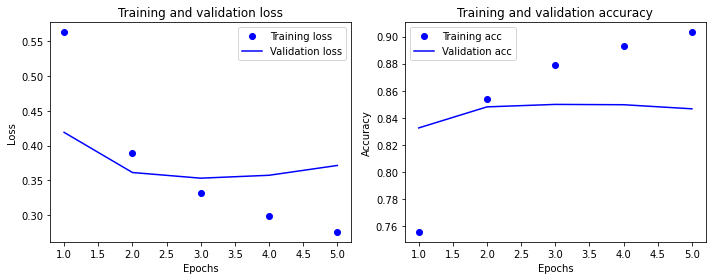

In [142]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 서브플롯을 생성합니다
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# 첫 번째 서브플롯: Training and Validation Loss
ax1.plot(epochs, loss, 'bo', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# 두 번째 서브플롯: Training and Validation Accuracy
ax2.plot(epochs, acc, 'bo', label='Training acc')
ax2.plot(epochs, val_acc, 'b', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# 서브플롯 간의 간격을 조정합니다
plt.tight_layout()

# 그래프를 출력합니다
plt.show()

2. 1D CNN

In [ ]:
vocab_size = 50000    # 어휘 사전의 크기입니다
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs= 5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

In [ ]:
results = model.evaluate(X_test,  y_test, verbose=1)
print(results)

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 서브플롯을 생성합니다
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# 첫 번째 서브플롯: Training and Validation Loss
ax1.plot(epochs, loss, 'bo', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# 두 번째 서브플롯: Training and Validation Accuracy
ax2.plot(epochs, acc, 'bo', label='Training acc')
ax2.plot(epochs, val_acc, 'b', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# 서브플롯 간의 간격을 조정합니다
plt.tight_layout()

# 그래프를 출력합니다
plt.show()

2. LSTM Stacking

In [ ]:
vocab_size = 50000    # 어휘 사전의 크기입니다
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,),mask_zero=True))
model.add(tf.keras.layers.LSTM(8,recurrent_dropout=0.25,return_sequences=True))
model.add(tf.keras.layers.LSTM(8,recurrent_dropout=0.25))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs= 5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

In [ ]:
results = model.evaluate(X_test,  y_test, verbose=1)
print(results)

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 서브플롯을 생성합니다
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# 첫 번째 서브플롯: Training and Validation Loss
ax1.plot(epochs, loss, 'bo', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# 두 번째 서브플롯: Training and Validation Accuracy
ax2.plot(epochs, acc, 'bo', label='Training acc')
ax2.plot(epochs, val_acc, 'b', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# 서브플롯 간의 간격을 조정합니다
plt.tight_layout()

# 그래프를 출력합니다
plt.show()

## 7) 학습된 Embedding 레이어 분석

In [143]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(50000, 16)


In [144]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec2.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-3, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 3개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(3,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [157]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['강추']
vector

array([-0.15956989,  0.06709275,  0.1838534 , -0.1328995 ,  0.17581128,
       -0.10071933, -0.03515879, -0.04138393, -0.07211126, -0.06571133,
        0.19327241, -0.06522657, -0.11421046,  0.1468657 ,  0.12326947,
        0.18790196], dtype=float32)

In [156]:
word_vectors.similar_by_word("긴장")

[('우민', 0.8803641200065613),
 ('동', 0.8456517457962036),
 ('갖춘다', 0.8405343294143677),
 ('그레이', 0.8384608626365662),
 ('아홉수', 0.8372870087623596),
 ('위치', 0.8360053896903992),
 ('저작권료', 0.8312565684318542),
 ('ㅜ내용이점점뻔해지는듯', 0.8265794515609741),
 ('Thing', 0.826439619064331),
 ('다카코', 0.8262174725532532)]

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
* 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
* 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. 참고 링크1, 참고 링크2

```
# 예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv[‘끝’]
```

In [42]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['안녕']
vector

array([ 2.8550365 , -2.5083623 ,  0.63134253,  1.2381471 ,  1.2327392 ,
       -0.72185796,  1.8402325 ,  0.97800475, -1.1051553 ,  2.0433369 ,
        0.69271207, -0.19798934, -1.86177   , -0.36222002,  0.3972282 ,
       -0.21830237,  0.85162693, -0.31651935,  1.6791793 , -2.6823583 ,
       -1.8238554 ,  1.9019375 ,  0.25607604, -0.57341754,  1.4750755 ,
        0.86539614, -2.1937923 ,  1.331522  ,  1.4148315 ,  0.05106315,
       -1.0021658 ,  0.3949725 , -1.4810442 ,  2.4344177 , -2.0451741 ,
        4.163476  , -1.9220031 , -0.6334712 , -1.1372192 ,  0.19194362,
       -0.5145045 , -0.1731505 ,  0.77141196,  1.1994339 ,  0.5596351 ,
        1.6327816 ,  1.6391085 ,  2.224425  ,  1.0831126 ,  0.10987365,
        0.67111415, -1.64053   ,  0.20209534, -1.7971501 , -0.64727396,
       -1.1733613 ,  1.2080375 , -1.1791579 ,  0.24168837,  1.9009135 ,
        2.6488237 , -2.7944257 , -0.8682773 , -2.8367517 , -0.14049563,
       -0.4478784 , -3.1858766 ,  0.61623126, -1.3198127 ,  0.80

In [43]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word_vectors.wv.similar_by_word("긴장")

[('긴장감', 0.7897169589996338),
 ('갈등', 0.745145857334137),
 ('혼란', 0.7212201952934265),
 ('불안', 0.709709882736206),
 ('반목', 0.700858473777771),
 ('불안감', 0.6817017793655396),
 ('불신', 0.6665791273117065),
 ('알력', 0.6642228364944458),
 ('마찰', 0.6541054844856262),
 ('흥분', 0.6478731632232666)]

> 네이버영화리뷰사전보다는 정확성이 훨씬 좋은게 느껴진다!

In [44]:
vocab_size = 50000    
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 word_vectors 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(3,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [69]:
from tensorflow.keras.initializers import Constant

vocab_size = 50000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 2, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(2))
model.add(tf.keras.layers.Conv1D(16, 2, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(2))
model.add(tf.keras.layers.Conv1D(16, 2, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(2))
model.add(tf.keras.layers.Conv1D(16, 2, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(2))
model.add(tf.keras.layers.Conv1D(16, 2, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 55, 100)           5000000   
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 54, 16)            3216      
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 27, 16)            0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 26, 16)            528       
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 13, 16)            0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 12, 16)            528       
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 6, 16)           

In [70]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/15
196/196 [==============================] - 3s 11ms/step - loss: 0.6327 - accuracy: 0.6230 - val_loss: 0.5307 - val_accuracy: 0.7378
Epoch 2/15
196/196 [==============================] - 2s 9ms/step - loss: 0.4887 - accuracy: 0.7678 - val_loss: 0.4548 - val_accuracy: 0.7907
Epoch 3/15
196/196 [==============================] - 2s 9ms/step - loss: 0.4204 - accuracy: 0.8111 - val_loss: 0.4107 - val_accuracy: 0.8144
Epoch 4/15
196/196 [==============================] - 2s 9ms/step - loss: 0.3748 - accuracy: 0.8368 - val_loss: 0.3861 - val_accuracy: 0.8280
Epoch 5/15
196/196 [==============================] - 2s 9ms/step - loss: 0.3408 - accuracy: 0.8555 - val_loss: 0.3747 - val_accuracy: 0.8350
Epoch 6/15
196/196 [==============================] - 2s 9ms/step - loss: 0.3135 - accuracy: 0.8701 - val_loss: 0.3773 - val_accuracy: 0.8342
Epoch 7/15
196/196 [==============================] - 2s 9ms/step - loss: 0.2904 - accuracy: 0.8820 - val_loss: 0.3676 - val_accuracy: 0.8404
Epoch

In [71]:
# 테스트셋을 통한 모델 평가
results = model.evalbuate(X_test,  y_test, verbose=1)

print(results)

1563/1563 [==============================] - 4s 3ms/step - loss: 0.4738 - accuracy: 0.8332
[0.47377830743789673, 0.8332099914550781]


# 회고
* 가장 힘든 프로젝트였다. 변수를 선택해야 하는 경우가 가장 많았던 듯 합니다.
* 트랜스포머를 확실히 이해했으면 사용해 봤을 듯 합니다.